In [1]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

def undersample_images_labels(images, labels, sample_per_class=100):
    undersampled_images = []
    undersampled_labels = []
    for class_code in DataSolarModules['class_code'].unique():
        class_indices = np.where(DataSolarModules['class_code'] == class_code)[0]
        np.random.shuffle(class_indices)
        undersampled_images.extend(images[class_indices[:sample_per_class]])
        undersampled_labels.extend(labels[class_indices[:sample_per_class]])
    undersampled_images = np.array(undersampled_images)
    undersampled_labels = np.array(undersampled_labels)
    return undersampled_images, undersampled_labels

In [5]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)

In [6]:
# Undersample images and labels
undersampled_images, undersampled_labels = undersample_images_labels(images, labels, sample_per_class=100)

In [7]:
# Define perplexity values
perplexity_values = [5, 10, 20, 30, 50]

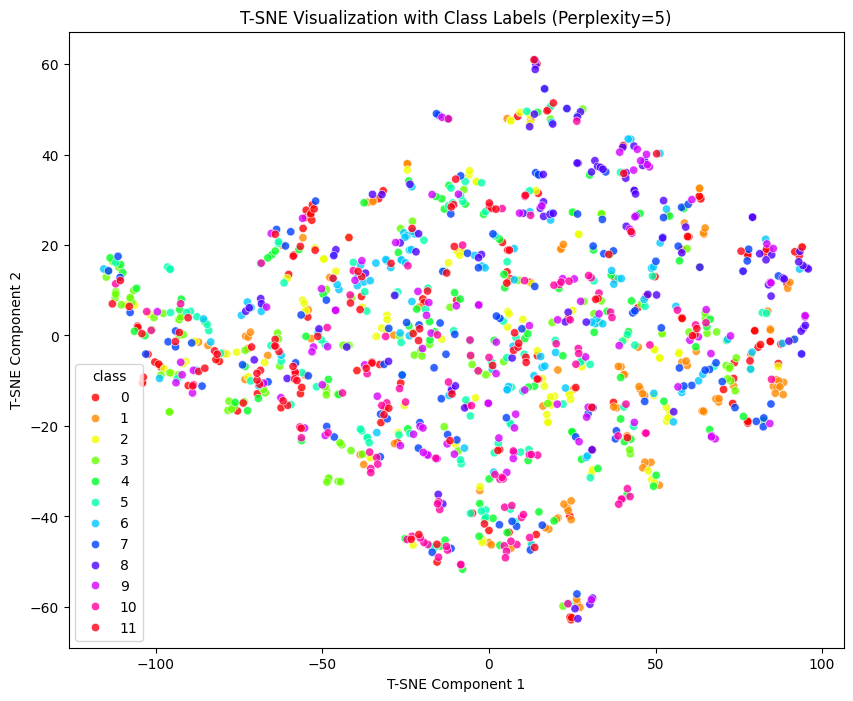

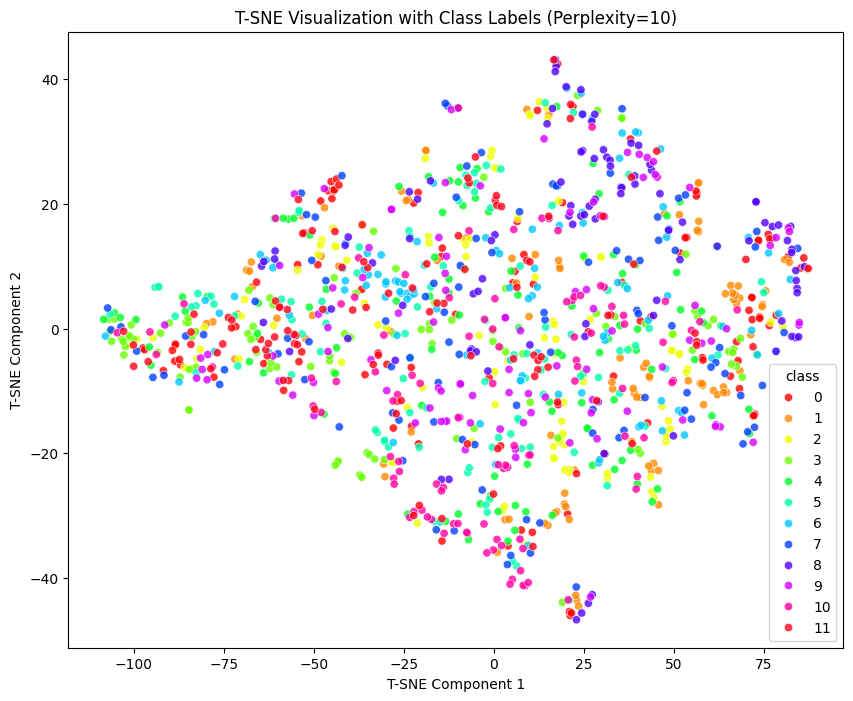

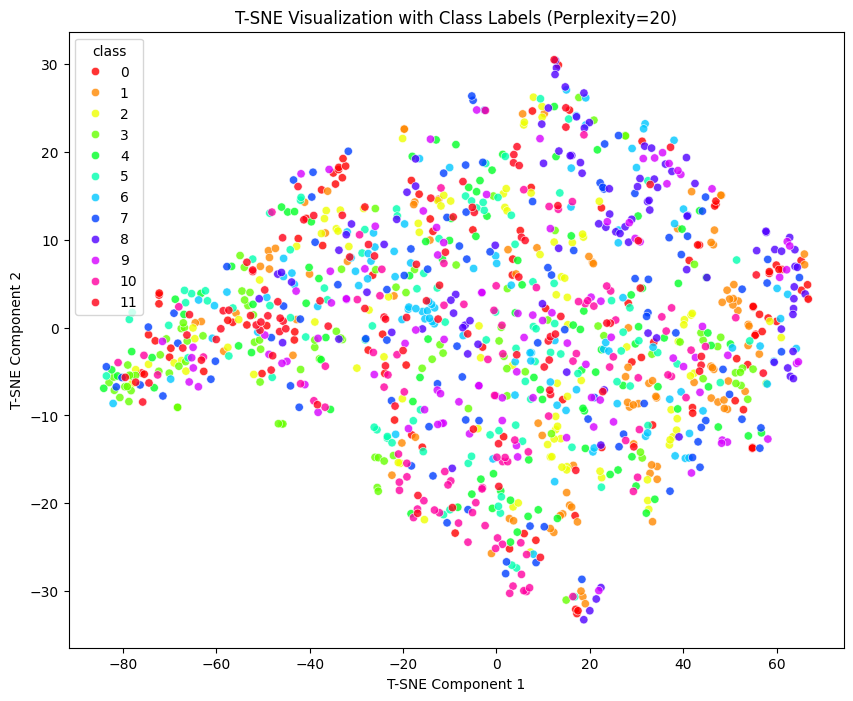

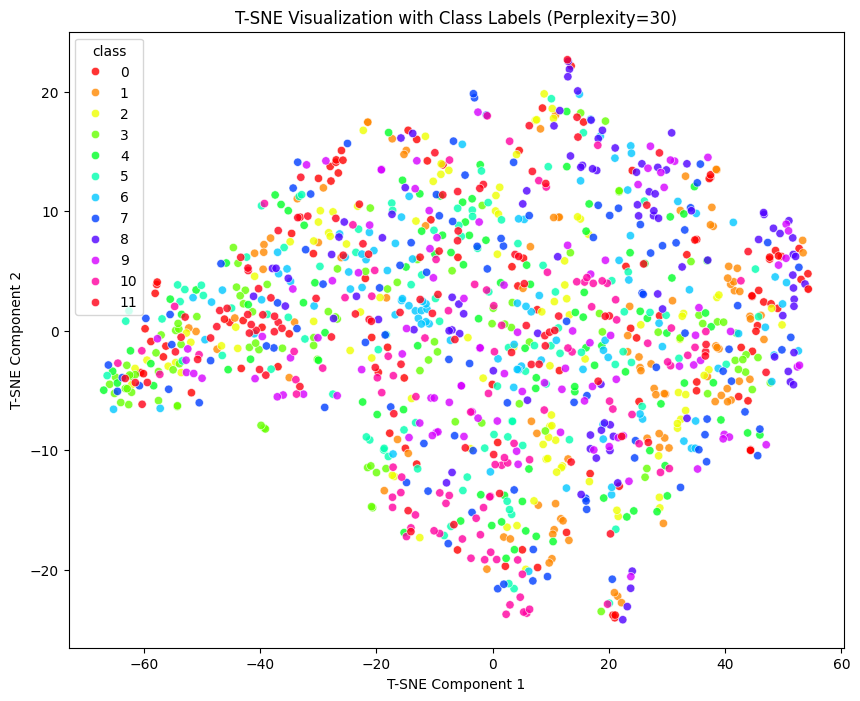

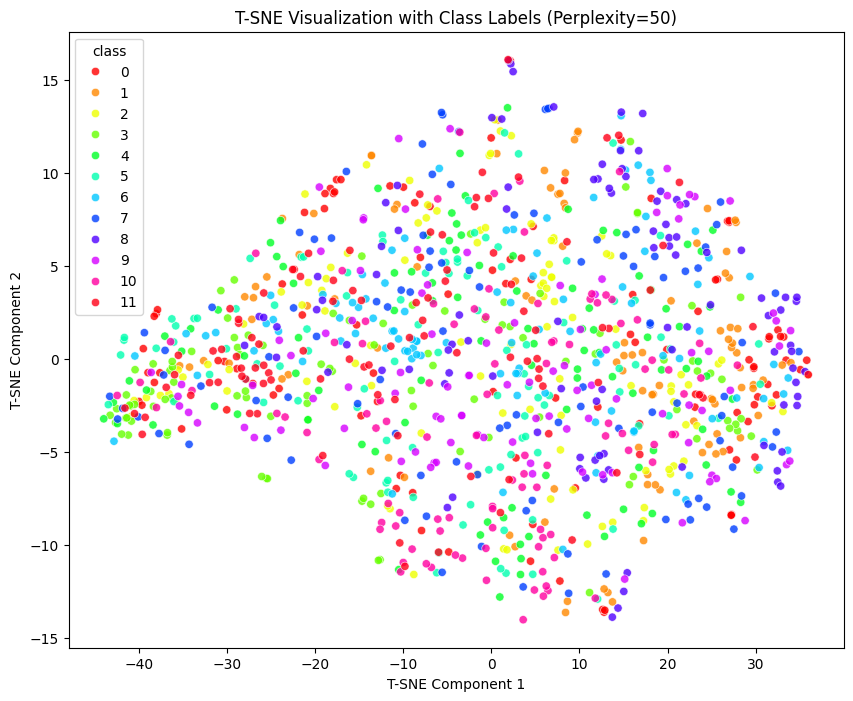

In [8]:
# Iterate over perplexity values for T-SNE visualization with class labels
for perplexity in perplexity_values:
    # Reduce dimensionality using T-SNE with different perplexity values
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(undersampled_images.reshape(undersampled_images.shape[0], -1))

    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])
    tsne_df['class'] = np.repeat([class_to_number[class_name] for class_name in DataSolarModules['anomaly_class'].unique()], 100)

    # Plot the T-SNE visualization with class labels
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='tsne1', y='tsne2',
        hue='class',
        palette='hsv',
        data=tsne_df,
        legend='full',
        alpha=0.8
    )
    plt.title(f'T-SNE Visualization with Class Labels (Perplexity={perplexity})')
    plt.xlabel('T-SNE Component 1')
    plt.ylabel('T-SNE Component 2')
    plt.show()

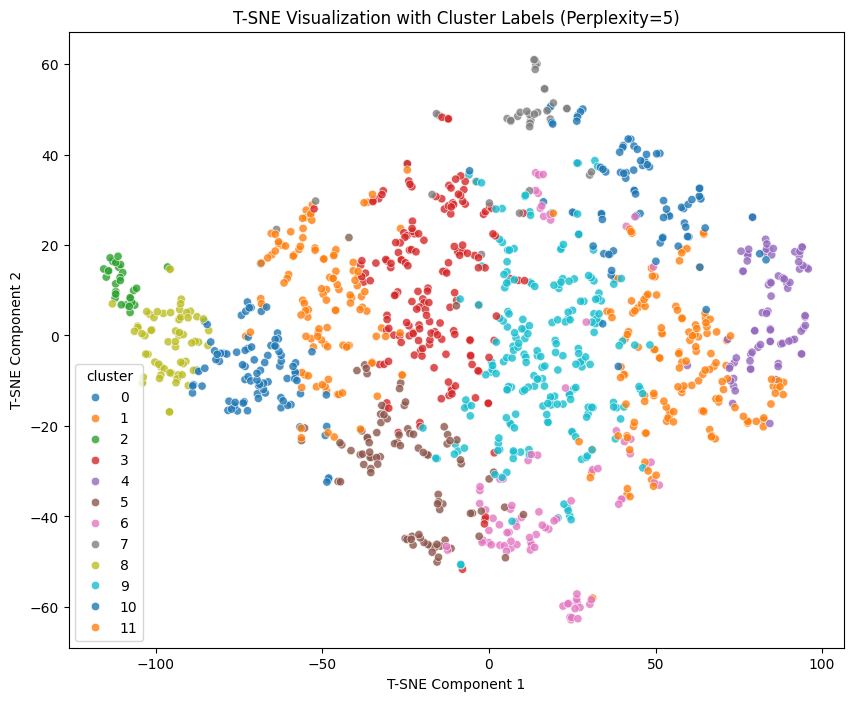

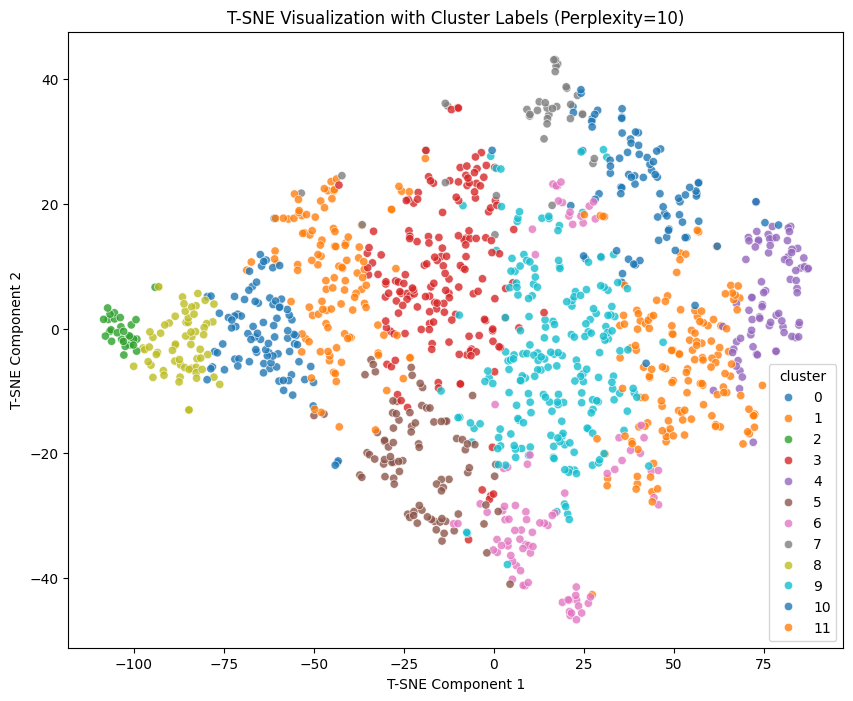

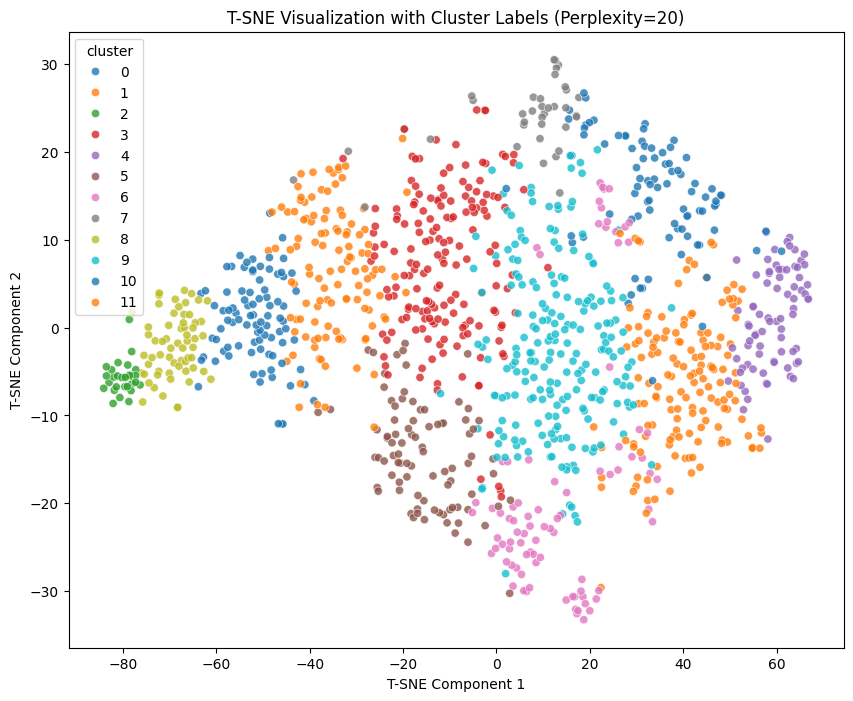

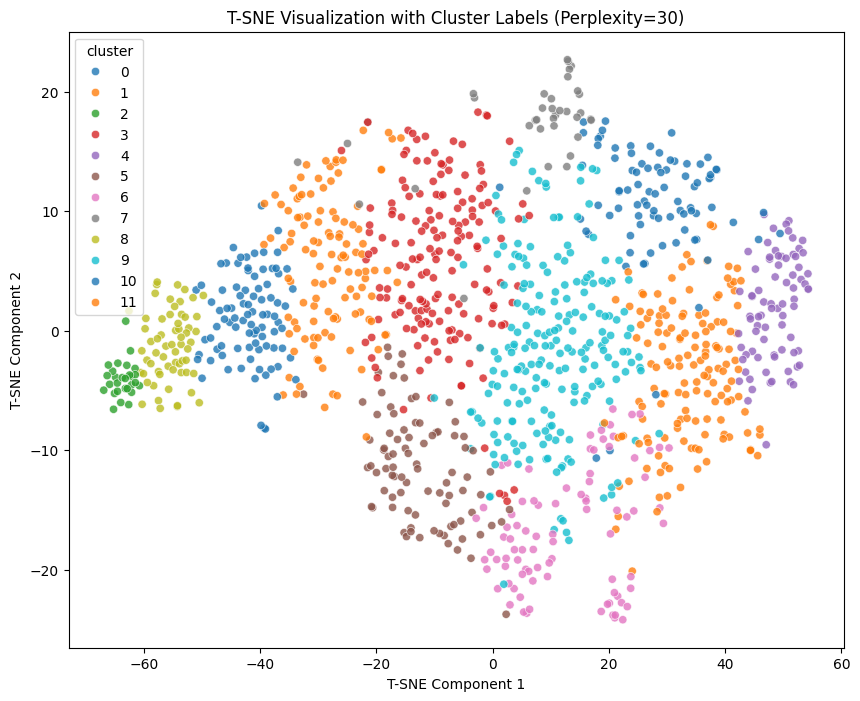

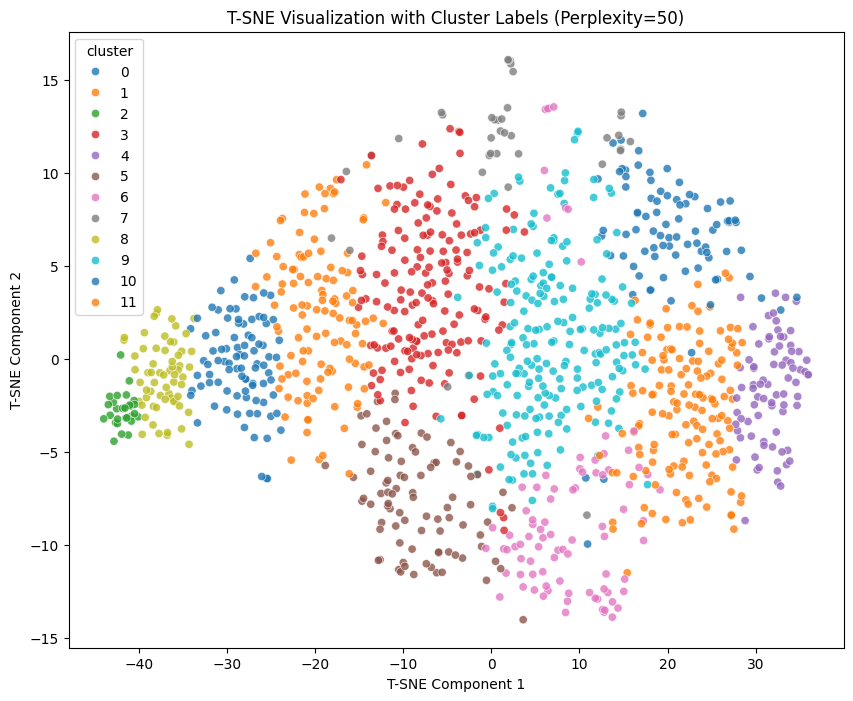

In [9]:
# Iterate over perplexity values for T-SNE visualization with cluster labels
for perplexity in perplexity_values:
    # Reduce dimensionality using T-SNE with different perplexity values
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(undersampled_images.reshape(undersampled_images.shape[0], -1))

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=len(Classes), random_state=42)
    cluster_labels = kmeans.fit_predict(undersampled_images.reshape(undersampled_images.shape[0], -1))

    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])
    tsne_df['cluster'] = cluster_labels

    # Plot the T-SNE visualization with cluster labels
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='tsne1', y='tsne2',
        hue='cluster',
        palette='tab10',
        data=tsne_df,
        legend='full',
        alpha=0.8
    )
    plt.title(f'T-SNE Visualization with Cluster Labels (Perplexity={perplexity})')
    plt.xlabel('T-SNE Component 1')
    plt.ylabel('T-SNE Component 2')
    plt.show()